# V. Mapping dieback detections

---

Now that we have parameters suitable (linked to a specific method) for the early detection on time series of satellite images, we can use the NRT package to produce an image of the diebacks spread.

---

# 0. Install NRT package (optional)

Depending of your Python environment, you can install the NRT Package in different ways. Here, we choose to install the package in our current session (uncomment the line of code if necessary).

In [1]:
#!pip install nrt

## 1. Import librairies
First, we import some basic librairies.

In [2]:
import os
import pickle
import datetime as dt
import matplotlib.pyplot as plt

We also import the spatial librairies

In [3]:
import xarray as xr
import rasterio as rio
import geopandas as gpd
import numpy as np

...And the NRT package!

In [4]:
from nrt_utils import Nrt_run

---

## 2. Import VI time-series as datacube

We process the CRSWIR time-series. The datacube, stored in a NETCDF file, is loaded as an xarray object.

In [5]:
with open('nrt_var.txt', 'rb') as f:
    dict_var = pickle.load(f)

startdate = dict_var['startdate']
enddate = dict_var['enddate']
output_dir = dict_var['output_dir']

In [6]:
vi_mask = xr.open_dataset(
    os.path.join(output_dir, f'S2TS_{startdate}-{enddate}_vi-mask.nc')
    )
ar_index = vi_mask.crswir

---

## 3. Creation of a "non-forest" mask

The use of a mask is not mandatory. However, this makes it possible to limit the calculations to the "forest" pixels, and also to improve the readability of the output products. To create this mask, we must rasterize a vector layer which outlines the forest, respecting the dimensions (x/y shape, transform and crs) of our CRSWIR datacube.

In [7]:
ar_shape = (vi_mask.sizes['y'], vi_mask.sizes['x'])
ar_transform = vi_mask.rio.transform()
out_crs = 'epsg:3035'

In [8]:
vector = gpd.read_file(r"data_ref/bd-foret_p33.gpkg")
geom = [geom for geom in vector.to_crs(out_crs).explode(index_parts=True).geometry]

# Rasterize vector using the shape and coordinate system of the raster
rasterized = rio.features.rasterize(geom,
                                    out_shape=ar_shape,
                                    fill=0,
                                    out=None,
                                    transform=ar_transform,
                                    all_touched=False,
                                    default_value=1,
                                    dtype=None)

---

## 4. Launch of NRT model

Now, we can run a NRT model over a time-series of satellite images (until now, we did it on pixels identified by point coordinates). 

### 4.1. Method, variables

Before running NRT package, we must choose the detection method, define the parameters values and the "pivot" date in order to split the time-series into a fitting period and a monitoring period.

In [9]:
# method and parameters
method = 'IQR'
extrap = {'sensitivity': 1.2, 'boundary': 5}
# pivot date (between fitting and monitoring periods)
pdate = dt.datetime(2018, 6, 30)

# output directory and file
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# output raster file
filename = f"monitor_{method}.tif"
outfile = os.path.join(output_dir, filename)

### 4.2. Production of the detection map
Then, we can run the `NRT package`. Here, we call it through the `nrt_utils` add-on.

In [10]:
test = Nrt_run(ar_index, method, pdate)
test.nrt_run(extrap, outfile, mask=rasterized)

The result is an image with two bands:
- band 1 presents the forest mask (true, false)
- band 2 presents the detections, pixels value refer to the detection date in Unix format.

---

## 5. Visualization

The visualization of detections is very important and can also be an assessment criterion. In fact, the spread of dieback due to the presence of bark beetles occurs from tree to tree. Consequently, detections often appear in the form of concentric rings, with the oldest contaminations in the center.

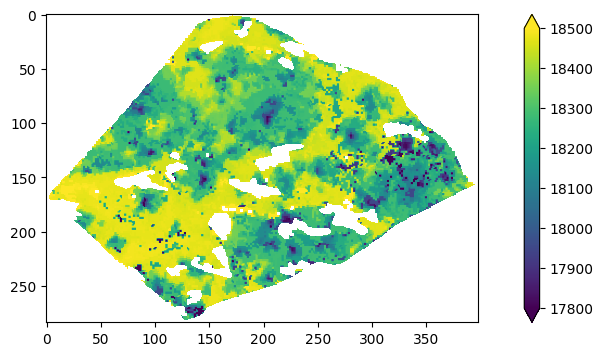

In [11]:
# open the image
dataset = rio.open(outfile)
# select band 2
detection = dataset.read(2)
# apply transparency to background
detection = np.ma.masked_where(detection == 0, detection)

# plot
fig, ax = plt.subplots(figsize = (12,4))
ano = ax.imshow(detection, cmap='viridis', vmin=17800, vmax=18500) #'RdYlGn'
fig.colorbar(ano, ax=ax, extend='both')